In [1]:
# 先知晓一下当前的目录地址
!pwd

/root/GW


In [2]:
# 安装必要的程序包
!pip install --upgrade lalsuite -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [3]:
# https://git.ligo.org/lscsoft/lalsuite/-/issues/300
import lal
lal.__version__

/tmp/ipykernel_10586/1428922197.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


'7.6.1'

In [4]:
import torch
torch.__version__

'2.5.1+cu124'

In [5]:
import os
print(os.getcwd())
os.chdir('/root/GW')
print(os.getcwd())

/root/GW
/root/GW


In [6]:
# 把脚本里的所有关联的程序包、类、函数都 load 一下
from main import *
from utils import *

loss 0.0015, train acc 1.000, test acc 0.900
8164.5 examples/sec on cuda


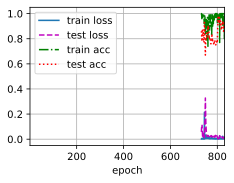

In [7]:
# 初始化数据生成 class
nsample_perepoch = 100  # 每个epoch的样本数
dataset_train = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 训练数据集
dataset_test = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 测试数据集

# 创建一个DataLoader
data_loader = DataLoader(dataset_train, batch_size=32, shuffle=True,)  # 训练数据加载器
test_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)  # 测试数据加载器

device = torch.device('cuda')  # 使用CUDA设备

# 模型和损失历史的输出路径
checkpoint_dir = './checkpoints_cnn/'

# 创建模型    
net, epoch, train_loss_history = load_model(checkpoint_dir)  # 加载模型
net.to(device);  # 将模型转移到设备上

# 优化器参数
lr = 0.003  # 学习率
total_epochs = 100  # 总的训练轮数
total_epochs += epoch  # 加上已经训练过的轮数
output_freq = 1  # 输出频率

# 训练模型
train(net, lr, nsample_perepoch, epoch, total_epochs,
      dataset_train, data_loader, test_iter,
      train_loss_history, checkpoint_dir, device, notebook=True)

In [8]:
dataset_train.strains.shape

(100, 1, 2, 16384)

In [9]:
# 加载必要的库
import lal  # https://git.ligo.org/lscsoft/lalsuite/-/issues/300
from main import *
from utils import *
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    y_list = []  # 初始化标签列表
    with torch.no_grad():  # 不进行梯度计算
        for X, y in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y = y.to(device).to(torch.long)  # 将标签转移到设备上并转换为长整型
            y_hat = net(X)  # 使用模型进行预测

            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            labels = y.cpu().numpy().tolist()  # 将标签转换为列表

            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
            y_list.extend(labels)  # 将标签添加到标签列表
    return np.asarray(y_hat_list), np.asarray(y_list)  # 返回预测结果和标签的numpy数组```

In [10]:
nsample_perepoch = 1000 # num of injections
snr = 20  # 信噪比

dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch)
data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)

GPU available? True


In [11]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e731.pt


/root/GW/main.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p / files[0])


In [12]:
y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

In [13]:
fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
auc = roc_auc_score(y_list, y_hat_list)
auc

np.float64(0.9980199999999999)

In [14]:
index = np.argmax(thresholds < 0.5)

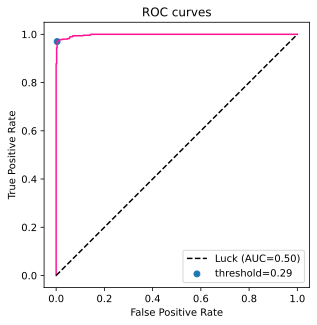

In [15]:
plt.plot(fpr, tpr, color="deeppink")
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
plt.scatter(fpr[index], tpr[index], label=f'threshold={thresholds[index]:.2f}')
plt.axis("square")
# plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 4/4 [00:41<00:00, 10.35s/it]


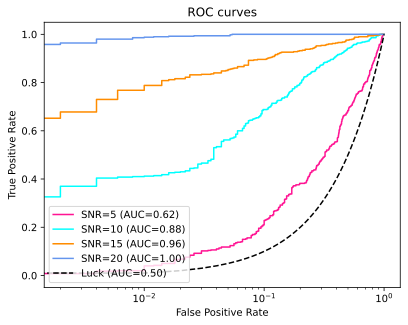

In [16]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

nsample_perepoch = 1000
snr_list = [5, 10, 15, 20]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    plt.plot(fpr, tpr, color=next(colors), label=f'SNR={snr} (AUC={auc:.2f})')
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

100%|██████████| 3/3 [00:29<00:00,  9.74s/it]


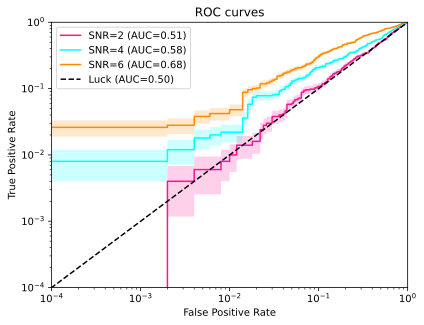

In [17]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

def sigma(n, tp):
    """

    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

nsample_perepoch = 1000
snr_list = [2, 4, 6]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, _ = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    fpr_error = [sigma(len(y_list)/2., t) for t in fpr]
    tpr_error = [sigma(len(y_list)/2., t) for t in tpr]
    
    color = next(colors)
    plt.plot(fpr, tpr, color=color, label=f'SNR={snr} (AUC={auc:.2f})')
    plt.fill_between(fpr, tpr+tpr_error, tpr-tpr_error, alpha=0.2, facecolor=color, zorder=0)
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.xlim(1e-4,1)
plt.ylim(1e-4,1)
plt.legend()
plt.show()

In [18]:
#!bash gen_test_data.sh

In [19]:
#import lal
#import _pickle as pickle
#from tqdm import tqdm
#from main import *
#from utils import *

In [20]:
#sizeofeach = 100
#groud_truth = []
#test_dataset = []

#for snr in tqdm([2,4,5,6,7,8,9,10,15,20,25,30]):
    #test_data_addr = f'BBH_testing_1s_8192Hz_10Ksamp_25n_iSNR{snr}_H1det_astromass_1seed_ts_0.sav'
    #with open(test_data_addr, 'rb') as rfp:
        #data = pickle.load(rfp)
        #index = np.random.randint(len(data[1]), size=sizeofeach)

        #groud_truth.extend(data[1][index].tolist())
        #test_dataset.append(np.expand_dims(data[0][index], 1))
#groud_truth = np.asarray(groud_truth)
#test_dataset = np.concatenate(test_dataset)

#groud_truth.shape, test_dataset.shape

In [21]:
#import pandas as pd
#pd.Series(groud_truth).value_counts()

In [22]:
#import pandas as pd
#pd.DataFrame({'id': range(len(groud_truth)),
              #'Public': groud_truth,
              #'Usage': ('Public',)*len(groud_truth)}).to_csv('ground_truth.csv', index=False)

In [23]:
#np.save('test', test_dataset)
# np.save('groud_truth', groud_truth)

In [24]:
#import lal
#import _pickle as pickle
#from tqdm import tqdm
#from main import *
#from utils import *

#def evaluate_submissoin_gpu(net, data_iter, device=None):
    #"""使用GPU计算模型在数据集上的预测结果"""
    #if isinstance(net, nn.Module):
       #net.eval()  # 设置为评估模式
        #if not device:
           #device = next(iter(net.parameters())).device  # 获取设备信息
    #softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    #y_hat_list = []  # 初始化预测结果列表
    #with torch.no_grad():  # 不进行梯度计算
        #for X in data_iter:  # 遍历数据集
            #X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            #y_hat = net(X)  # 使用模型进行预测
            #preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            #y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
    #return y_hat_list

In [25]:
#test_dataset = np.load('test.npy')
#test_dataset.shape

In [26]:
#data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)

In [27]:
# load model
#device = torch.device('cuda')

# Where we output our model and loss history
#checkpoint_dir = './checkpoints_cnn/'

# Creat model
#net, epoch, train_loss_history = load_model(checkpoint_dir)
#net.to(device);

In [28]:
#results = evaluate_submissoin_gpu(net, data_loader, device)
#len(results)

In [29]:
# results

In [30]:
#import pandas as pd
#pd.DataFrame({'id': range(len(results)),
              #'target': results}, index=None).to_csv('submission.csv', index=False)